In [ ]:
import numpy as np
import pandas as pd
import copy

import nltk
nltk.download('punkt')


In [ ]:
def get_pos_tagged_sentences(sentences):
    pos_tagged_sentences = []

    for sentence in sentences:
        words = sentence.split(" ")
        sequence = []
        for word in words:
            splited = word.split("_")
            if ( len(splited) == 2 ):
                root, tag = splited
                tag = tag.replace("$", "-")
                sequence.append( (root, tag) )

        pos_tagged_sentences.append(sequence)

    return pos_tagged_sentences

In [ ]:
def tag_vocab_set(pos_tagged_sentences):
    tag_set = set ()
    vocab_set = set ()

    freq_tag = {} 
    freq_vocab = {}

    for sentence in pos_tagged_sentences:
        for pos_tag in sentence:
            root, tag = pos_tag
            if ( not root in freq_vocab ):
                freq_vocab[root] = 1
            else: 
                freq_vocab[root] = 1

            if ( not tag in freq_tag ):
                freq_tag[tag] = 1
            else:
                freq_tag[tag] += 1

            tag_set.add(tag)
            vocab_set.add(root)

    return list(tag_set), list(vocab_set), freq_tag, freq_vocab

In [ ]:
# emmission probability
# probability of a word given a tag
# [P(o1 | s1) o1 is the word, s1 is the tag
# prob count(brown and abj)/count(adj)

def get_emmission_matrix(pos_tagged_sentences, tag_set, vocab_set):

    n = len(tag_set)
    m = len(vocab_set)
    transition_matrix = np.zeros((m,n))

    mapping_tags = {}
    index = 0
    for tag in tag_set:
        mapping_tags[tag] = index
        index += 1

    mapping_vocab = {}
    index = 0
    for tag in vocab_set:
        mapping_vocab[tag] = index
        index += 1

    count_tags = {}
    for sentence in pos_tagged_sentences:
        for i in range(len(sentence)):
            tag = sentence[i][1]
            word = sentence[i][0]

            transition_matrix[mapping_vocab[word]][mapping_tags[tag]] += 1

            if (not tag in count_tags):
                count_tags[tag] = 1
            else:
                count_tags[tag] += 1
                
    count_tags
    df_dic = {}
    i = 0

    transition_matrix = transition_matrix.T
    for tag in tag_set:
        df_dic[tag] = transition_matrix[i]
        i += 1

    df = pd.DataFrame(df_dic, columns=tag_set, index = vocab_set)

    # for word in vocab_set:
    for tag in count_tags:
        df[tag] = df[tag]/count_tags[tag] 

    return df


In [ ]:
# transition probability
# Compute the Transition probabilities (probability of getting a tag t2 given that the tag for
# previous word was t1) on the training set.

def get_transition_matrix(pos_tagged_sentences, tag_set):

    n = len(tag_set)
    transition_matrix = np.zeros( (n,n) )

    mapping = {}
    count_tags = {}
    index = 0
    for tag in tag_set:
        mapping[tag] = index
        index += 1

    for sentence in pos_tagged_sentences:
        for i in range(len(sentence) -1):

            t1 = sentence[i][1]
            t2 = sentence[i+1][1]
            
            x = mapping[t1]
            y = mapping[t2]
            transition_matrix[x][y] += 1
            if (not t1 in count_tags):
                count_tags[t1] = 1
            else:
                count_tags[t1] += 1

    df_dic = {}
    i = 0
    for tag in tag_set:
        df_dic[tag] = transition_matrix[i]
        i += 1
    df = pd.DataFrame(df_dic, columns = tag_set, index = tag_set)
    for tag in count_tags:
        df[tag] = df[tag]/count_tags[tag] 

    return df


In [ ]:
# 5. Implement viterbi algorithm:
# a. Given a sentence, for each word in sentence:
# b. Get the transition probabilities and emission probabilities.
# c. Assign the tag which has the maximum probability (emission * transition).
def vertibi_algo(sentence, transition_matrix, tag_list, emmission_matrix):

    pred_list = []
    actual_tag = []
    for i in range(len(sentence)):
        word, tag = sentence[i]
        actual_tag.append(tag)

        prob = 0
        assoicated_tag = 'NN'
        for tag in tag_list:
            if (i == 0):
                tp = transition_matrix['.'].get(tag)
                ep = emmission_matrix[tag].get(word)
                if ( ep != None and tp*ep > prob ):
                    prob = tp*ep
                    assoicated_tag = tag

            else:
                tp = transition_matrix[pred_list[i-1]].get(tag)
                ep = emmission_matrix[tag].get(word)

                if ( ep != None and tp*ep > prob ):
                    prob = tp*ep
                    assoicated_tag = tag

        pred_list.append(assoicated_tag)
    
    return pred_list, actual_tag

In [ ]:
def accuracy_2grm(pos_tagged_sentences_test, transition_matrix, emmission_matrix, tag_set_train):

    total = 0
    correct = 0
    pred_actual_list = []
    for sentence in pos_tagged_sentences_test:

        prediction, actual_tag = vertibi_algo(sentence, transition_matrix, tag_set_train, emmission_matrix)
        pred_actual_list.append((prediction, actual_tag))
        total += len(actual_tag)

        for i in range(len(prediction)):
            if (actual_tag[i] == prediction[i]):
                correct += 1
    
    accuracy = correct/total
    return accuracy, pred_actual_list

In [ ]:
def confusion_matrix(pred_actual_list, tag_set):

    tag_list = list(tag_set)
    n = len(tag_list)
    dict_tag = {}
    for tag in tag_list:
        dict_tag[tag] = [0]*n

    df_conusion = pd.DataFrame(dict_tag, index = tag_list, columns= tag_list).fillna(0)

    for pred_actual in pred_actual_list:

        prediction, actual_tag = pred_actual
        for i in range(len(prediction)):
            
            if ( not actual_tag[i] in df_conusion.index ):
                df_add = pd.DataFrame({actual_tag[i] : [0]*n}, index = tag_list, columns=[actual_tag[i]]).fillna(0)
                frames = [df_conusion, df_add]
                df_conusion = pd.concat(frames, axis = 1).fillna(0)

                df_add = pd.DataFrame({actual_tag[i] : [0]*n}, columns = tag_list, index=[actual_tag[i]]).fillna(0)
                frames = [df_conusion, df_add]
                df_conusion = pd.concat(frames, axis = 0).fillna(0)

            if (actual_tag[i] == prediction[i]):
                df_conusion.loc[actual_tag[i], actual_tag[i]] += 1

            else:
                df_conusion.loc[actual_tag[i], prediction[i]] += 1

    return df_conusion

In [ ]:
# i. True Positives: Actually true, predicted true.
# ii. True Negatives: Actually false, predicted false.
# iii. False Positives: Actually false, predicted true.
# iv. False Negatives: Actually true, predicted false.

def calculate_precision(df_confusion, tag_set):
    # x = actual and y = predicted
    n = df_confusion.shape[0]
    tag_f1 = {}
    tag_prec = {}
    tag_recall = {}
    for i in range(n):
        row = df_confusion.iloc[i]
        total = row.sum()
        positives = df_confusion.iloc[i,i]

        if (total != 0 ):
            tp = positives/total

        col = df_confusion.iloc[:, i].sum()
        p = df_confusion.iloc[i,i]
        if (col != 0):
            fp = (col - p)/col
            fn = p/col

        prec = tp/(tp+fp)
        recall = tp/(tp+fn)

        f1_score = (2*prec*recall)/(prec + recall)
        tag_f1[ df_confusion.iloc[i].name ] = [f1_score]
        tag_prec[df_confusion.iloc[i].name] = [prec]
        tag_recall[df_confusion.iloc[i].name] = [recall]

    return tag_f1, tag_prec, tag_recall

In [ ]:
# transition probability
# Compute the Transition probabilities (probability of getting a tag t2 given that the tag for
# previous word was t1) on the training set.

def get_transition_matrix(pos_tagged_sentences, tag_set):

    n = len(tag_set)
    transition_matrix = np.zeros( (n,n) )

    mapping = {}
    count_tags = {}
    index = 0
    for tag in tag_set:
        mapping[tag] = index
        index += 1

    for sentence in pos_tagged_sentences:
        for i in range(len(sentence) -1):

            t1 = sentence[i][1]
            t2 = sentence[i+1][1]
            
            x = mapping[t1]
            y = mapping[t2]
            transition_matrix[x][y] += 1
            if (not t1 in count_tags):
                count_tags[t1] = 1
            else:
                count_tags[t1] += 1

    df_dic = {}
    i = 0
    for tag in tag_set:
        df_dic[tag] = transition_matrix[i]
        i += 1
    df = pd.DataFrame(df_dic, columns = tag_set, index = tag_set)
    for tag in count_tags:
        df[tag] = df[tag]/count_tags[tag] 

    return df


In [ ]:
def transition_matrix_3gram(pos_tagged_sentences):

    dict_sent = {}
    count_tags = {}

    for sentence in pos_tagged_sentences:
        for i in range(len(sentence) -2):
            t1 = sentence[i][1]
            t2 = sentence[i+1][1]
            t3 = sentence[i+2][1]
 
            if ((t1, t2, t3) in dict_sent):
                dict_sent[(t1, t2, t3)] += 1
            else:
                dict_sent[(t1, t2, t3)] = 1

            if ((t1, t2) in count_tags):
                count_tags[(t1, t2)] += 1
            else:
                count_tags[(t1, t2)] = 1

    return dict_sent, count_tags

In [ ]:
def vertibi_algo_3gram(dict_sent, count_tags, sentence, transition_matrix, tag_list, emmission_matrix):
    
    pred_list = []
    actual_tag = []
    for i in range(len(sentence)):
        word, tag = sentence[i]
        actual_tag.append(tag)

        prob = 0
        assoicated_tag = 'NN'
        for tag in tag_list:
            if (i == 0):
                tp = transition_matrix['.'][tag]
                ep = emmission_matrix[tag].get(word)
                if ( ep != None and tp*ep > prob ):
                    prob = tp*ep
                    assoicated_tag = tag

            elif (i==1):
                a = dict_sent.get(('.', pred_list[i-1], tag))
                b = count_tags.get((pred_list[i-1], tag))

                tp = 0
                if ( not a == None and not b == None and b > 0):
                    tp = a/b
                ep = emmission_matrix[tag].get(word)
                if ( ep != None and tp*ep > prob ):
                    prob = tp*ep
                    assoicated_tag = tag


            else:
                a = dict_sent.get((pred_list[i-2], pred_list[i-1], tag))
                b = count_tags.get((pred_list[i-2], pred_list[i-1]))
                tp = 0
                if (not a == None and not b == None and b > 0):
                    tp = a/b
                ep = emmission_matrix[tag].get(word)

                if ( ep != None and tp*ep > prob ):
                    prob = tp*ep
                    assoicated_tag = tag

        pred_list.append(assoicated_tag)
    
    return pred_list, actual_tag

In [ ]:
# vertibi_algo_3gram(dict_sent, count_tags, pos_tagged_sentences_train[0], transition_matrix, list (tag_set))
def accuracy_3gram(pos_tagged_sentences_test, transition_matrix, emmission_matrix, dict_sent, count_tags, tag_list):

    total = 0
    correct = 0
    pred_actual_list = []
    for sentence in pos_tagged_sentences_test:

        prediction, actual_tag = vertibi_algo_3gram(dict_sent, count_tags, sentence, transition_matrix, tag_list, emmission_matrix)
        pred_actual_list.append((prediction, actual_tag))
        total += len(actual_tag)

        for i in range(len(prediction)):
            if (actual_tag[i] == prediction[i]):
                correct += 1
    
    accuracy = correct/total
    return accuracy, pred_actual_list

In [ ]:
def calc_f1_score(df_f1_score, freq_tag):
    score = 0
    freq_sum = 0
    for tag in freq_tag:

        if ( tag in df_f1_score and tag in freq_tag ):
            score += df_f1_score.get(tag)*freq_tag.get(tag)
            freq_sum += freq_tag[tag]

    return score/freq_sum

In [ ]:
filename = "Brown_train.txt"
f = open(filename, "r")
data = f.read()

In [ ]:
sentences = data.split("\n")
n = len(sentences)
print(n, sentences[0])

10084 The_AT Fulton_NP-TL County_NN-TL Grand_JJ-TL Jury_NN-TL said_VBD Friday_NR an_AT investigation_NN of_IN Atlanta's_NP$ recent_JJ primary_NN election_NN produced_VBD ``_`` no_AT evidence_NN ''_'' that_CS any_DTI irregularities_NNS took_VBD place_NN ._.


In [ ]:
# accuracy = Correct predictions/ Total predictions.
def calculate_accuracy_and_precison_2grm(train_set, test_set):

    pos_tagged_sentences_train = get_pos_tagged_sentences(train_set)
    pos_tagged_sentences_test = get_pos_tagged_sentences(test_set)

    tag_set, vocab_set, freq_tag, freq_vocab = tag_vocab_set(pos_tagged_sentences_train)

    transition_matrix = get_transition_matrix(pos_tagged_sentences_train, tag_set)
    emmission_matrix = get_emmission_matrix(pos_tagged_sentences_train, tag_set, vocab_set)

    # return emmission_matrix

    # (pos_tagged_sentences_test, transition_matrix, emmission_matrix, tag_set_train
    acc, pred_actual_list = accuracy_2grm(pos_tagged_sentences_test, transition_matrix, emmission_matrix, tag_set)
    print("Accuracy for 2Grm : ", acc)

    df_conusion = confusion_matrix(pred_actual_list, tag_set)

    tag_f1, prec, recall = calculate_precision(df_conusion, tag_set)
    df_f1_score = pd.DataFrame(tag_f1).dropna(axis = 'columns')
    f1 = calc_f1_score(df_f1_score, freq_tag)

    print("F1 Score of 2Grm : ", f1)

    return acc, f1, df_conusion


In [ ]:
def calculate_acc_f1_for_3grm(train_set, test_set):

    pos_tagged_sentences_train = get_pos_tagged_sentences(train_set)
    pos_tagged_sentences_test = get_pos_tagged_sentences(test_set)

    tag_set, vocab_set, freq_tag, freq_vocab = tag_vocab_set(pos_tagged_sentences_train)

    dict_sent, count_tags = transition_matrix_3gram(pos_tagged_sentences_train)
    transition_matrix = get_transition_matrix(pos_tagged_sentences_train, tag_set)
    emmission_matrix = get_emmission_matrix(pos_tagged_sentences_train, tag_set, vocab_set)
    
    acc, pred_actual_list = accuracy_3gram(pos_tagged_sentences_test, transition_matrix, emmission_matrix, dict_sent, count_tags, list(tag_set))
    print("Accuracy for 3Grm : ", acc)

    df_conusion_3gram = confusion_matrix(pred_actual_list, tag_set)
    tag_f1_3grm, prec, recall = calculate_precision(df_conusion_3gram, tag_set)

    df_f1_score = pd.DataFrame(tag_f1_3grm).dropna(axis = 'columns')
    f1 = calc_f1_score(df_f1_score, freq_tag)
    print("F1 Score for 3Grm : ", f1)

    return acc, f1, df_conusion_3gram


In [ ]:
calculate_accuracy_and_precison_2grm(sentences[:10000], sentences[10000:12000])

Accuracy for 2Grm :  0.8943089430894309


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


F1 Score of 2Grm :  0    0.638361
Name: AT, dtype: float64


(0.8943089430894309, 0    0.638361
 Name: AT, dtype: float64, <function __main__.confusion_matrix>)

In [ ]:
calculate_acc_f1_for_3grm(sentences[:10000], sentences[10000:12000])

Accuracy for 3Grm :  0.795269770879527


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


F1 Score for 3Grm :  0    0.614014
Name: AT, dtype: float64


In [ ]:
def k_fold_validation_2grm(sentences):

    n = len(sentences)
    k = 3

    part1 = sentences[0:n//k]
    part2 = sentences[n//k: n//k + n//k]
    part3 = sentences[n//k + n//k :]

    avg_acc = 0
    avg_f1 = 0

    # val1
    # test on part3
    p1 = copy.deepcopy(part1)
    p1.extend(part2)
    train = p1
    test = part3    
    acc, f1, confusion_matrix = calculate_accuracy_and_precison_2grm(train, test)
    print("Validation Part 1 Completed ... ")
    avg_acc += acc
    avg_f1 += f1

    # val2
    # test on part1
    p2 = copy.deepcopy(part2)
    p2.extend(part3)
    train = p2
    test = part1
    acc, f1, confusion_matrix = calculate_accuracy_and_precison_2grm(train, test)
    print("Validation Part 2 Completed ... ")
    avg_acc += acc
    avg_f1 += f1
    # val3
    # test on part2
    p3 = copy.deepcopy(part3)
    p3.extend(part1)
    train = p3
    test = part2
    acc, f1, confusion_matrix = calculate_accuracy_and_precison_2grm(train, test)
    print("Validation Part 3 Completed ... ")
    avg_acc += acc
    avg_f1 += f1

    print( "Average Accuracy : ", avg_acc/3, " Average F1 Score : ", avg_f1/3 )


In [ ]:
def k_fold_validation_3grm(sentences):

    n = len(sentences)
    k = 3

    part1 = sentences[0:n//k]
    part2 = sentences[n//k: n//k + n//k]
    part3 = sentences[n//k + n//k :]

    avg_acc = 0
    avg_f1 = 0

    # val1
    # test on part3
    p1 = copy.deepcopy(part1)
    p1.extend(part2)
    train = p1
    test = part3    
    acc, f1, confusion_matrix = calculate_acc_f1_for_3grm(train, test)
    print("Validation Part 1 Completed ... ")
    avg_acc += acc
    avg_f1 += f1

    # val2
    # test on part1
    p2 = copy.deepcopy(part2)
    p2.extend(part3)
    train = p2
    test = part1
    acc, f1, confusion_matrix = calculate_acc_f1_for_3grm(train, test)
    print("Validation Part 2 Completed ... ")
    avg_acc += acc
    avg_f1 += f1
    # val3
    # test on part2
    p3 = copy.deepcopy(part3)
    p3.extend(part1)
    train = p3
    test = part2
    acc, f1, confusion_matrix = calculate_acc_f1_for_3grm(train, test)
    print("Validation Part 3 Completed ... ")
    avg_acc += acc
    avg_f1 += f1

    print( "Average Accuracy : ", avg_acc/3, " Average F1 Score : ", avg_f1/3 )

In [ ]:
k_fold_validation(sentences)

Accuracy for 2Grm :  0.8395190304866502


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


F1 Score of 2Grm :  0    0.619141
Name: AT, dtype: float64
Validation Part 1 Completed ... 
Accuracy for 2Grm :  0.8359226747958521


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


F1 Score of 2Grm :  0    0.62695
Name: RB, dtype: float64
Validation Part 2 Completed ... 
Accuracy for 2Grm :  0.8564955480990251
F1 Score of 2Grm :  0    0.629172
Name: AT, dtype: float64
Validation Part 3 Completed ... 
Average Accuracy :  2.5319372533815274  Average F1 Score :  0    1.875263
Name: AT, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
avg_acc = 2.5319372533815274/3
avg_f1 = 1.875263/3
print( "Average Accuracy : ", avg_acc, " Average F1 Score : ", avg_f1 )

Average Accuracy :  0.8439790844605092  Average F1 Score :  0.6250876666666666


In [ ]:
k_fold_validation_3grm(sentences)

Accuracy for 3Grm :  0.7594797386858549


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


F1 Score for 3Grm :  0    0.592946
Name: AT, dtype: float64
Validation Part 1 Completed ... 
Accuracy for 3Grm :  0.7656248087070433


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


F1 Score for 3Grm :  0    0.602588
Name: RB, dtype: float64
Validation Part 2 Completed ... 
Accuracy for 3Grm :  0.7731512061084838
F1 Score for 3Grm :  0    0.602881
Name: AT, dtype: float64
Validation Part 3 Completed ... 
Average Accuracy :  0.7660852511671274  Average F1 Score :  0    0.599472
Name: AT, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
def most_misclassified_tags(sentences):
    pos_tagged_sentences_train = get_pos_tagged_sentences(sentences[:10000])
    pos_tagged_sentences_test = get_pos_tagged_sentences(sentences[10000:12000])

    tag_set, vocab_set, freq_tag, freq_vocab = tag_vocab_set(pos_tagged_sentences_train)

    transition_matrix = get_transition_matrix(pos_tagged_sentences_train, tag_set)
    emmission_matrix = get_emmission_matrix(pos_tagged_sentences_train, tag_set, vocab_set)

    acc, pred_actual_list = accuracy_2grm(pos_tagged_sentences_test, transition_matrix, emmission_matrix, tag_set)

    df_conusion = confusion_matrix(pred_actual_list, tag_set)

    tag_f1, prec, recall = calculate_precision(df_conusion, tag_set)

    misclass = []
    for tag in tag_f1:
        if ( tag_f1[tag][0] <= 0.5 ):
            misclass.append(tag)
    return misclass, df_conusion


In [ ]:
def stats_words(sentences):

    f = open("Brown_train.txt", "r")
    inputfile = f.read()
    tokens = nltk.tokenize.word_tokenize(inputfile)
    fd = nltk.FreqDist(tokens)
    fd.plot(30,cumulative=False)


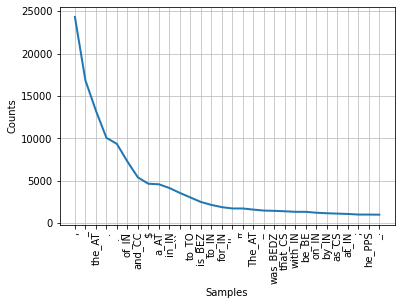

In [ ]:
plot_freq()

In [ ]:
misclass, confusion = most_misclassified_tags(sentences)
print(misclass)

['DTI', 'OD-TL', 'VBN-TL', 'DTI-HL', 'FW-AT+NP-TL', 'RP', 'PPSS-HL', 'NPS-HL', 'NPS-TL', 'EX+BEZ', 'FW-OD-TL', 'HV*', 'CS-TL', 'BER-TL', 'BEDZ*', 'JJS-TL', 'VBZ-HL', '``']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
f1, prec, recall = calculate_precision(confusion, tag_set)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
confusion.head(10)

,PPO,DOD*-TL,BER-HL,NN-,FW-AT,BE-TL,BER*,BEDZ,.,CD-HL,CD-,PPSS+BEM,MD*-HL,HVG,NNS-,IN-TL,PPSS+HVD,--,AT-HL,NP-TL-HL,OD,JJ-HL,FW-JJR,VBZ,NN-TL-HL,DT-HL,NR,CD-TL,AP,*-HL,RB-NC,BEN-TL,VBD,FW-CC,RB-TL,DOD,RP-TL,CD,NNS-TL,VBN-TL-HL,...,DTX,UH-HL,FW-JJ-TL,RBT,VB-HL,MD*,PPS+BEZ,HV,FW-PPO,WRB-TL,VB+PPO,NN-HL,PP-,JJT,IN-HL,PPS+MD,RB+BEZ,NP--HL,PPS-TL,CS-HL,)-HL,HVZ*,WPO-TL,PP--TL,AT,WRB,DO-HL,CC-HL,PPO-HL,FW-AT-HL,:-TL,RB-HL,.-HL,WDT-HL,(-HL,RP-HL,DO*,BEZ-HL,NP-,","
PPO,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DOD*-TL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BER-HL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NN-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FW-AT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BE-TL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BER*,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BEDZ,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD-HL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("Tag Wise Precision : ")
pd.DataFrame(prec)

Tag Wise Precision : 


,PPO,DOD*-TL,BER-HL,NN-,FW-AT,BE-TL,BER*,BEDZ,.,CD-HL,CD-,PPSS+BEM,MD*-HL,HVG,NNS-,IN-TL,PPSS+HVD,--,AT-HL,NP-TL-HL,OD,JJ-HL,FW-JJR,VBZ,NN-TL-HL,DT-HL,NR,CD-TL,AP,*-HL,RB-NC,BEN-TL,VBD,FW-CC,RB-TL,DOD,RP-TL,CD,NNS-TL,VBN-TL-HL,...,DTX,UH-HL,FW-JJ-TL,RBT,VB-HL,MD*,PPS+BEZ,HV,FW-PPO,WRB-TL,VB+PPO,NN-HL,PP-,JJT,IN-HL,PPS+MD,RB+BEZ,NP--HL,PPS-TL,CS-HL,)-HL,HVZ*,WPO-TL,PP--TL,AT,WRB,DO-HL,CC-HL,PPO-HL,FW-AT-HL,:-TL,RB-HL,.-HL,WDT-HL,(-HL,RP-HL,DO*,BEZ-HL,NP-,","
0,0.913043,0.913043,0.913043,0.913043,0.913043,0.913043,0.913043,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5,0.5,0.901734,0.901734,0.901734,1.0,1.0,0.857143,0.857143,0.857143,0.857143,0.902804,0.902804,0.902804,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
print("Tag Wise Recall : ")
pd.DataFrame(recall)

Tag Wise Recall : 


,PPO,DOD*-TL,BER-HL,NN-,FW-AT,BE-TL,BER*,BEDZ,.,CD-HL,CD-,PPSS+BEM,MD*-HL,HVG,NNS-,IN-TL,PPSS+HVD,--,AT-HL,NP-TL-HL,OD,JJ-HL,FW-JJR,VBZ,NN-TL-HL,DT-HL,NR,CD-TL,AP,*-HL,RB-NC,BEN-TL,VBD,FW-CC,RB-TL,DOD,RP-TL,CD,NNS-TL,VBN-TL-HL,...,DTX,UH-HL,FW-JJ-TL,RBT,VB-HL,MD*,PPS+BEZ,HV,FW-PPO,WRB-TL,VB+PPO,NN-HL,PP-,JJT,IN-HL,PPS+MD,RB+BEZ,NP--HL,PPS-TL,CS-HL,)-HL,HVZ*,WPO-TL,PP--TL,AT,WRB,DO-HL,CC-HL,PPO-HL,FW-AT-HL,:-TL,RB-HL,.-HL,WDT-HL,(-HL,RP-HL,DO*,BEZ-HL,NP-,","
0,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.5,0.497409,0.497409,0.497409,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,0.433333,0.433333,0.433333,0.5,0.5,0.5,0.5,0.5,0.5,0.469388,0.469388,0.469388,0.5,0.5,0.5,0.363636,0.363636,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.476923,0.454545,0.454545,0.454545,0.454545,0.454545,0.454545,0.454545,0.454545,0.454545,0.454545,0.454545,0.497006,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
print("Tag Wise F1 : ")
pd.DataFrame(f1)

Tag Wise F1 : 


,PPO,DOD*-TL,BER-HL,NN-,FW-AT,BE-TL,BER*,BEDZ,.,CD-HL,CD-,PPSS+BEM,MD*-HL,HVG,NNS-,IN-TL,PPSS+HVD,--,AT-HL,NP-TL-HL,OD,JJ-HL,FW-JJR,VBZ,NN-TL-HL,DT-HL,NR,CD-TL,AP,*-HL,RB-NC,BEN-TL,VBD,FW-CC,RB-TL,DOD,RP-TL,CD,NNS-TL,VBN-TL-HL,...,DTX,UH-HL,FW-JJ-TL,RBT,VB-HL,MD*,PPS+BEZ,HV,FW-PPO,WRB-TL,VB+PPO,NN-HL,PP-,JJT,IN-HL,PPS+MD,RB+BEZ,NP--HL,PPS-TL,CS-HL,)-HL,HVZ*,WPO-TL,PP--TL,AT,WRB,DO-HL,CC-HL,PPO-HL,FW-AT-HL,:-TL,RB-HL,.-HL,WDT-HL,(-HL,RP-HL,DO*,BEZ-HL,NP-,","
0,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.66436,0.66436,0.66436,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.585366,0.585366,0.585366,0.666667,0.666667,0.631579,0.631579,0.631579,0.631579,0.617647,0.617647,0.617647,0.666667,0.666667,0.666667,0.533333,0.533333,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.645833,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.664,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
